In [23]:
%load_ext autoreload
%autoreload 2
import platform
import os

gdrive = False
linux = True 
# Detect if we're running on a Linux system
linux = platform.system() == "Linux"

# Detect if we're in a Google Colab environment by attempting to import google.colab
try:
    from google.colab import drive
# Mount Google Drive
    drive.mount('/content/drive')
    gdrive=True
except ImportError:
    gdrive = False

# Detect if we're in a Kaggle environment by checking for a Kaggle-specific environment variable
kaggle = "KAGGLE_URL_BASE" in os.environ

environment_flags = {'kaggle': kaggle, 'gdrive': gdrive, 'linux': linux}
print("Environment settings:", environment_flags)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Environment settings: {'kaggle': False, 'gdrive': False, 'linux': True}


In [24]:
import os
os.chdir('/home/zano/Documents/TESI/TESI')
print(os.getcwd())

/home/zano/Documents/TESI/TESI


## install requirements

## IMPORTS

In [ ]:
import os
import tifffile
import glob
import random
import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import numpy as np
# from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import StratifiedKFold
from monai.data import Dataset, DataLoader
# from classes.PrintShapeTransform import PrintShapeTransform
from monai.utils.misc import set_determinism
import monai
print(monai.__version__)
#import tifffile
#from monai.networks.nets import DenseNet121
import torch.nn.functional as F
from monai.visualize import GradCAMpp,GradCAM  
#kaggle = input("Are you on Kaggle? Enter 'T' for True or 'F' for False: ")
kaggle = False
if gdrive:
    import os

    # Change to the desired directory:
    os.chdir('/content/drive/MyDrive/TESI/TESI/notebooks')

    # Verify the current directory:
    print(os.getcwd())

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
    
from utils.reproducibility_functions import set_global_seed
set_global_seed(42)

2.6.0+cu124
1.4.0


## PARAMETERS THAT WILL GET LOGGED ON MLFLOW

In [26]:
import sys
# Add the parent directory to Python path to make configs package accessible
from configs.ConfigLoader import ConfigLoader
sys.path.append(os.path.dirname(os.getcwd()))

yaml_path = "/home/zano/Documents/TESI/TESI/configs/4c/base.yaml"
colab_yaml_path = "/content/drive/MyDrive/TESI/TESI/configs/base.yaml"
try:
    cfg = ConfigLoader(yaml_path)
except ValueError as e:
    print(f"Error loading configuration: {e}")
    print("Please ensure the YAML file contains all required sections.")
    raise

# Set a fixed random seed for reproducibility for all the soruces of randomness
# python, numpy, torch, monai
SEED = 42
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
set_determinism(seed=SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
import torch.backends.cudnn as cudnn
cudnn.deterministic = True   # forces deterministic convolution algorithms
cudnn.benchmark     = False  # turn off data-dependent autotune
# monai.utils.set_determinism(seed=SEED)

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/4c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.5, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 4, 'out_channels': 2, 'dropout_prob': 0.1, 'patch_size': [32, 32]}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': False, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceL

# UNIFIED DATA SELECTION

In [27]:
from utils.directory_functions import get_data_directory, get_base_directory
num_input_channels = int(input("Enter the number of input channels (3 or 4): "))

data_dir = get_data_directory(kaggle, gdrive,linux, num_input_channels=num_input_channels)
print("data dir:",data_dir)
base_dir = get_base_directory(kaggle, gdrive, linux)
print("base_dir:",base_dir)
# start mlflow ui
from utils.mlflow_functions import *
from utils.directory_functions import *

tracking_uri = get_tracking_uri(gdrive,kaggle,linux)
mlflow.set_tracking_uri(tracking_uri)
start_mlflow_ui(tracking_uri) # start mlflow ui

3 channels input
you are in linux
/home/zano/Documents/TESI/3c_MIP_new
data dir: /home/zano/Documents/TESI/3c_MIP_new
base_dir: /home/zano/Documents/TESI/TESI
you are on linux
Linux detected, setting tracking URI
Final Tracking URI: /home/zano/Documents/TESI/mlruns
Does the directory exist? True


In [28]:
import ipywidgets as widgets
from IPython.display import display

CLASS_NAME_SETS = {
    "MSA vs Control": ["MSA", "control"],
    "MSA vs PD": ["MSA", "PD"],
    "MSA-P vs MSA-C": ["MSA-P", "MSA-C"],
    "MSA-P vs PD": ["MSA-P", "PD"],
    "PD vs MSA-P vs MSA-C": ["PD", "MSA-P", "MSA-C"]
}

dropdown = widgets.Dropdown(
    options=list(CLASS_NAME_SETS.keys()),
    value="MSA vs PD",
    description='Class Set:',
    style={'description_width': 'initial'}
)

def on_dropdown_change(change):
    """
    Update the class_names variable when the dropdown selection changes.
    """
    global class_names
    if change['type'] == 'change' and change['name'] == 'value':
        class_names = CLASS_NAME_SETS[change['new']]
        print(f"class_names set to: {class_names}")


class_names = CLASS_NAME_SETS[dropdown.value]

dropdown.observe(on_dropdown_change)

display(dropdown)

Dropdown(description='Class Set:', index=1, options=('MSA vs Control', 'MSA vs PD', 'MSA-P vs MSA-C', 'MSA-P v…

In [29]:
print(f"class_names set to: {class_names}") #chekc if the class names are set correctly

class_names set to: ['MSA', 'PD']


# DATA EXTRACTION

{'MSA': '/home/zano/Documents/TESI/3c_MIP_new/MSA', 'PD': '/home/zano/Documents/TESI/3c_MIP_new/PD'}
Class directories:
{'MSA': '/home/zano/Documents/TESI/3c_MIP_new/MSA', 'PD': '/home/zano/Documents/TESI/3c_MIP_new/PD'}
MSA images (before filtering): 'gh' count: 83, 'vaso' count: 0
After removing 'vaso', MSA images: 'gh' count: 83, 'vaso' count: 0
PD images (before filtering): 'gh' count: 57, 'vaso' count: 0
After removing 'vaso', PD images: 'gh' count: 57, 'vaso' count: 0


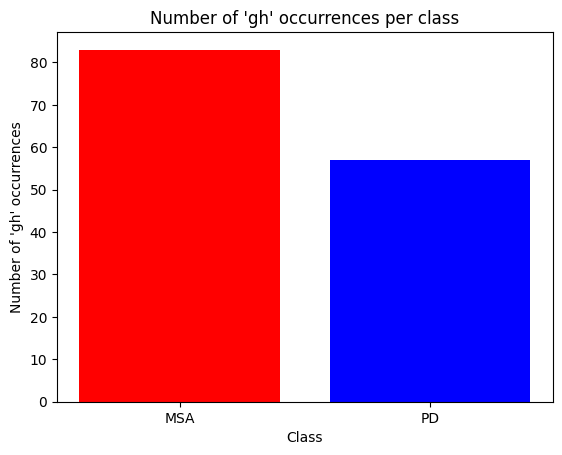


Checking image shapes:
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5435 gh.tif.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5435 gh2.tif.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA image: MAX_5463 gh.tif.tif  dt

In [ ]:
# Create a dictionary mapping each class to its directory
class_dirs = {}
three_classes = (len(class_names) == 3)

for class_name in class_names:
    class_dirs[class_name] = os.path.join(data_dir, class_name)
    
print(class_dirs)
if three_classes:
    class2_name, class1_name, class0_name = class_names
    class2_dir, class1_dir, class0_dir = class_dirs.values()
else:
    class1_name, class0_name = class_names
    class1_dir, class0_dir = class_dirs.values()

print("Class directories:")
print(class_dirs)

# Dictionaries to store image paths and counts for each class
images_paths_dict = {}
counts_dict = {}

# Loop over classes to process each folder
for class_name in class_names:
    class_dir = class_dirs[class_name]
    image_paths = sorted(glob.glob(os.path.join(class_dir, "*.tif")))
    
    # Check if images were found; otherwise raise an error
    if not image_paths:
        raise FileNotFoundError(f"No TIFF image file found in {class_dir}")
    
    # Count occurrences of 'gh' and 'vaso' in the filenames (using .lower() for case insensitivity)
    gh_count = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"{class_name} images (before filtering): 'gh' count: {gh_count}, 'vaso' count: {vaso_count}")
    
    # Filter out images that contain 'vaso' (if needed)
    image_paths = [path for path in image_paths if 'vaso' not in os.path.basename(path).lower()]
    gh_count_after = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count_after = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"After removing 'vaso', {class_name} images: 'gh' count: {gh_count_after}, 'vaso' count: {vaso_count_after}")
    
    # Store the filtered image paths and counts for later use
    images_paths_dict[class_name] = image_paths
    counts_dict[class_name] = {"gh_count": gh_count_after, "vaso_count": vaso_count_after}

# Visualize the number of 'gh' counts per class in a bar chart
plt.figure()
plt.xlabel("Class")
plt.ylabel("Number of 'gh' occurrences")
plt.title("Number of 'gh' occurrences per class")
bar_heights = [counts_dict[cn]["gh_count"] for cn in class_names]
bar_colors = ['red', 'blue', 'lightblue']
plt.bar(class_names, bar_heights, color=bar_colors)
plt.show()

# --- Debug: Check image shapes after initial loading ---
print("\nChecking image shapes:")
for class_name, image_paths in images_paths_dict.items():
    for path in image_paths:
        img = tifffile.imread(path)  # Read image as a numpy array
        print(f"{class_name} image: {os.path.basename(path)}  dtype: {img.dtype}, shape: {img.shape}")

# Combine image paths and labels for the three classes; 
# the label here is simply the index of the class in class_names (0, 1, 2)
combined = [] # List to store tuples of (image_path, label)
for label, class_name in enumerate(class_names):
    for path in images_paths_dict[class_name]:
        combined.append((path, label))
# print("\nSample of combined image paths and labels:", combined[:5])
random.shuffle(combined)  # Shuffle the combined list to mix classes

# Optionally, determine the minority label for resampling purposes
counts = {label: len(images_paths_dict[class_name]) for label, class_name in enumerate(class_names)}
minority_label = min(counts, key=lambda k: counts[k])
print(f"\nMinority label for resampling purposes: {minority_label}")

# Unzip the combined list back into separate tuples (if needed)
images_paths, labels = zip(*combined)
print("\nSample of image paths:", images_paths[:5])
print("Total images found:", len(combined))

# Optionally, convert to NumPy arrays (helpful for further processing or k-fold splitting)
images_paths_np = np.array(images_paths)
labels_np = np.array(labels)
print("\nSample of image paths (NumPy):", images_paths_np[:5])
print((labels_np))
#print(X)

## TEST SET SPLIT

In [31]:
# NB the test set must be splitted BEFORE oversampling to avoid data leakage!
# -------------------------------------------------------------------------
#from sklearn.model_selection import train_test_split
#returns numpy arrays containing the paths to images and the labels
# print(cfg.data_splitting["random_seed"])
train_images_paths, test_images_paths, train_true_labels, test_true_labels = train_test_split(
    images_paths_np,
    labels_np,
    test_size = cfg.data_splitting["test_set_size"],
    stratify=labels,
    random_state=42
)

test_images_paths_np = np.array(test_images_paths)
test_true_labels_np = np.array(test_true_labels)
print("train images paths:", train_images_paths)
print("true test labels:", test_true_labels)
# # For the cross-validation, we'll use train_images_paths and labels_temp
train_images_paths_np = np.array(train_images_paths) #contains the images paths
train_labels_np = np.array(train_true_labels) #contains the labels
print(f"{train_images_paths_np.shape[0]} training images")
print(f"{len(test_images_paths)} test images")
#test_images_paths = [os.path.basename(path) for path in test_images_paths]
print(test_images_paths)
print(type(train_images_paths))

train images paths: ['/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_7179.lif - 7179 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh  n2.tif'
 '/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_5978 gh.tif.tif'
 '/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_6351.lif - 6351 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif'
 '/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_6179 gh2.tif.tif'
 '/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_6424.lif - 6424 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif'
 '/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_6577.lif - 6577 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif'
 '/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_7229.lif - 7229 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif'
 '/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_6179 gh.tif.tif'
 '/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_6060 gh.tif.tif'
 '/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_6696.lif - 6696 DL VIP red Sinapto 

# SUPERVISED LEARNING


## training augmentations

In [ ]:
from configs import ConfigLoader
import utils.transformations_functions as tf
import utils.monai_transformation_functions as mtf
from configs.ConfigLoader import ConfigLoader

from classes.ModelManager import ModelManager
available_models = ["densenet121", "resnet18", "resnet18", "resnet50"]

yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/densenet121.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = "imagenet" if transfer_learning else None # 'microscopynet' or "imagenet" or 'imagenet-microscopynet' 
assert pretrained_weights in [None,"microscopynet", "imagenet", "imagenet-microscopynet"], "pretrained_weights must be one of [None, 'microscopynet', 'imagenet', 'imagenet-microscopynet']"
            # indicates that the encoder was first pretrained on imagenet and then finetuned on microscopynet
model_library = "monai" # or "torchvision" or "monai" pretraining dataset, either 'microscopynet' or 
assert model_library in ["torchvision", "monai"], "model_library must be one of ['torchvision', 'monai']"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg, color_transforms=color_transforms)
# train_transforms, val_transforms, test_transforms = mtf.get_transforms(cfg, color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
# print(f"Number of classes in the dataset: {num_classes}")
using_cosine_scheduler = False
# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
# model = model.to(device)  # First, move to the target device
# model = model.float() 
print(model)
# print(cfg.get_model_input_channels())

# if model.__class__.__name__ == "ViT":
#     print("Using ViT hence it requires custom training and validation functions")
#     train_epoch = train_epoch_vit
#     val_epoch = val_epoch_vit

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/3c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceLROnPlateau', 'factor': 0.

## TRAINING

## NESTED K FOLD WITH HYP(LR) TUNING

This code trains an image classifier using nested cross-validation.
The outer loop evaluates the model's performance, while the inner loop (using Optuna) tunes the learning rate.
For each outer fold, Optuna finds the best learning rate by minimizing validation loss on inner folds.
The model is then retrained on the entire outer training set with this optimal learning rate and evaluated on the outer set. The final results are the average performance metrics across all outer folds. Techniques like oversampling, undersampling, and early stopping are used to improve the model's robustness and generalization.

NB: total number of epoch: n_outer_folds × n_trials × n_inner_folds × inner_num_epochs.

### outer test as test


In [33]:
import pandas as pd
import re
def extract_patient_id(image_path):
    # Example: parse from the file name
    # In real code, you might have a different pattern
    match = re.search(r'(\d{4})', image_path)
    if match:
        return match.group(1)
    else:
        return "UNKNOWN"

# Build a DataFrame
df = pd.DataFrame({
    "image_path": images_paths_np,
    "label": labels_np
})

df["patient_id"] = df["image_path"].apply(extract_patient_id) # extract the patient id from the image path and create a new column
display(df)

# Ensure everything is string or int
df["patient_id"] = df["patient_id"].astype(str) # convert the patient id to a string

# Now group by patient to get a single label per patient.
# If every patient truly has exactly one label, we can just take .first()
# create a patient_label_df by filtering df patient_label_df( "patient_id","label")
patient_label_df = df.groupby("patient_id", as_index=False)["label"].first() # group by patient id and take the first label for each patient
display(patient_label_df)

unique_pat_ids = patient_label_df["patient_id"].values  # we need these to stratify for patient
print(f"Unique patient IDs: {unique_pat_ids}")
print(f"Number of unique patients: {len(unique_pat_ids)}")
pat_labels     = patient_label_df["label"].values
print(f"Unique patient labels: {pat_labels}")

display(patient_label_df)

# Determine the number of classes automatically from the dataset labels
unique_overall_labels = np.unique(labels_np) # Or df['label'].unique()
num_classes = len(unique_overall_labels)
print(f"Detected {num_classes} unique classes: {sorted(unique_overall_labels)}")

# Crucial Check: Ensure labels are 0, 1, ..., N-1 for nn.CrossEntropyLoss
expected_labels = set(range(num_classes)) # set of all possible labels (0...N-1)
actual_labels = set(unique_overall_labels) # set of all actual labels found in labels_np
if expected_labels != actual_labels:
    # Depending on your data, you might raise an error or attempt re-encoding.
    # If labels are e.g., [1, 2, 3], they MUST be mapped to [0, 1, 2].
    raise ValueError(f"Labels must be contiguous integers starting from 0 (i.e., 0 to N-1). Found: {sorted(actual_labels)}")

,image_path,label,patient_id
0,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_72...,1,7222
1,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_60...,1,6008
2,/home/zano/Documents/TESI/3c_MIP_new/PD/MAX_76...,1,7688
3,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_5...,0,5717
4,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_7...,0,7105
...,...,...,...
135,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_6...,0,6599
136,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_7...,0,7105
137,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_7...,0,7179
138,/home/zano/Documents/TESI/3c_MIP_new/MSA/MAX_5...,0,5435


,patient_id,label
0,4092,0
1,4121,0
2,5358,0
3,5435,0
4,5463,0
...,...,...
69,7544,1
70,7579,0
71,7677,1
72,7688,1


Unique patient IDs: ['4092' '4121' '5358' '5435' '5463' '5717' '5745' '5753' '5767' '5776'
 '5878' '5881' '5904' '5954' '5969' '5978' '5992' '5996' '6008' '6046'
 '6053' '6060' '6085' '6179' '6308' '6311' '6320' '6323' '6326' '6337'
 '6340' '6351' '6363' '6366' '6375' '6383' '6424' '6427' '6459' '6485'
 '6491' '6571' '6577' '6593' '6599' '6616' '6651' '6657' '6663' '6690'
 '6696' '6749' '6773' '6791' '7105' '7120' '7132' '7144' '7155' '7179'
 '7185' '7191' '7222' '7229' '7239' '7284' '7293' '7343' '7461' '7544'
 '7579' '7677' '7688' '7710']
Number of unique patients: 74
Unique patient labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1]


,patient_id,label
0,4092,0
1,4121,0
2,5358,0
3,5435,0
4,5463,0
...,...,...
69,7544,1
70,7579,0
71,7677,1
72,7688,1


Detected 2 unique classes: [0, 1]


## TRAINING FUNCTIONS

In [ ]:
import utils.transformations_functions as tf
from configs.ConfigLoader import ConfigLoader
from classes.ModelManager import ModelManager
# Flags ####################
transfer_learning_flag = True
########################################
available_models = ["densenet121","resnet18","resnet50"]
color_flag = False
libraries = ["torchvision"]
pretrained_weights_list = ["imagenet-microscopynet"] #!TODO use , "imagenet-microscopynet"
# pretrained_weights = None #"imagenet-microscopynet"
cfg.set_batch_size(16)
cfg.set_freezed_layer_index(None)
for model_name in available_models:
    for pretrained_weights in pretrained_weights_list:
        for library in libraries:
            yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/{model_name}.yaml"
            cfg = ConfigLoader(yaml_path) 
            cfg.set_transfer_learning(transfer_learning_flag)
            transfer_learning = cfg.get_transfer_learning()
            # if model_name == "densenet121":
            #     cfg.set_freezed_layer_index(236)
            # pretrained if needed
            # pretrained_weights = "imagenet" if transfer_learning else None # 'microscopynet' or "imagenet"
            # set the model library
            # model_library = "torchvision" # or "torchvision" or "monai"
            # color_transforms = False
            # train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=use_color_transform)
            model_manager = ModelManager(cfg, library=library)
            # Verify the number of unique labels in the dataset
            num_classes = len(np.unique(train_labels_np))
            print(f"Number of classes in the dataset: {num_classes}")
            using_cosine_scheduler = False
            # Ensure the model's output matches the number of classes
            model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

            print(model)

            from classes.NestedCVStratifiedByPatient import NestedCVStratifiedByPatient
            # cfg.set_freezed_layer_index(None)
            experiment = NestedCVStratifiedByPatient(
                df=df, cfg=cfg, labels_np=labels_np, pat_labels=pat_labels, unique_pat_ids=unique_pat_ids,
                pretrained_weights = pretrained_weights,
                class_names = class_names,model_manager=model_manager, num_folds=6
            )
            # cfg.set_freezed_layer_index(None)

            # hold_out_cv = True
            using_cosine_scheduler = False

            per_fold_training_metrics, outer_fold_test_results = experiment.run_experiment()


            from utils.mlflow_functions import log_SSL_run_to_mlflow
            def get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc"):
                """
                Get the index of the best fold based on a specified metric.

                Args:
                    outer_fold_test_results (list of dict): List containing test results for 
                        each outer fold. Each element should be a dictionary with metrics 
                        as keys.
                    metric (str): The metric name to use for selecting the best fold. 
                        Default is "test_balanced_acc".

                Returns:
                    int: The index of the fold with the highest value for the specified metric.

                Example:
                    best_idx = get_best_fold_idx(results, metric="test_f1")
                """

                print(outer_fold_test_results)
                best_fold_idx = np.argmax([r[metric] for r in outer_fold_test_results])
                # print(f"Best Balanced Accuracy Fold Index: {best_bac_fold_idx}")
                best_fold_result = outer_fold_test_results[best_fold_idx]
                print(f"Best {metric} Fold Result: {best_fold_result}")
                fold_idx = best_fold_result["fold"]
                return fold_idx

            #loading the best model for the metric selected, it's then used for computing gradcams during logging
            best_fold_idx = get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc")
            model_instance_for_logging, _ = experiment._get_model_and_device()
            model_instance_for_logging.eval()
            try:
                model_instance_for_logging.load_state_dict(torch.load(f"best_model_fold_{best_fold_idx}.pth"))
            except FileNotFoundError:
                raise FileNotFoundError("Could not find best_model_fold_{best_fold_idx}.pth")
            except Exception as e:
                raise Exception(f"Error loading model weights: {str(e)}")
            
            # Now, call the logging function:
            train_transforms, val_transforms, test_transforms = experiment.get_current_fold_transforms()
            # Now, call the logging function:
            log_SSL_run_to_mlflow(
                environmentFlags=environment_flags,
                cfg=experiment.cfg,
                model=model_instance_for_logging,
                class_names=experiment.class_names,
                fold_results = outer_fold_test_results,
                per_fold_metrics=per_fold_training_metrics,
                hold_out_cv=True, # Or experiment.cfg.path.to.hold_out_flag
                test_transforms=val_transforms,
                all_images_paths_np=images_paths_np, # Paths from the DF used in CV
                all_labels_np=experiment.labels_np, # Labels corresponding to all_images_paths_np from CV
                test_images_paths_np=test_images_paths_np, # Assuming this is a SEPARATE hold-out set
                test_true_labels_np=test_true_labels_np,   # Labels for the SEPARATE hold-out set
                yaml_path=yaml_path,
                color_transforms=color_flag, # Or experiment.cfg.path.to.color_transforms
                model_library=library,       # Or experiment.cfg.path.to.model_library
                pretrained_weights=pretrained_weights, # Or experiment.cfg.path.to.pretrained_weights
                # encoder_type="none", # If these become active, source them from experiment.cfg
                # pretrained_backbone_path = "none",
            )

In [ ]:
!jupyter nbconvert --to script supervised_learning.ipynb

[NbConvertApp] Converting notebook supervised_learning.ipynb to script
[NbConvertApp] Writing 22206 bytes to supervised_learning.py
